#### 3. **XGBoost Modeling with MTA Delays Integration**

##### *Observations & Data Integration*

This modeling phase explored how **NYC subway delays**, combined with rideshare trip characteristics and weather, impact hourly rideshare demand (`trip_count`).

The dataset was built by merging:
- Hourly rideshare data (Uber and Lyft)
- Hourly weather observations
- Daily MTA subway delay counts (aggregated and joined on date)

Preprocessing steps included:
- One-hot encoding for categorical variables (`service`, `conditions`)
- Type conversion for boolean fields
- Aggregation of `total_delays` and temporal alignment across datasets
- Final confirmation of a fully numeric, model-ready feature matrix

##### *Model Consideration*

We selected the **XGBoost Regressor** to model non-linear relationships and feature interactions across time, weather, trip, and delay dimensions. The model aimed to predict **hourly rideshare volume** using all available features.

##### *Model Performance*

- **RMSE**: **1588.20**  
  The model’s predictions are off by ~1,588 trips per hour on average, which is acceptable given the high range of trip counts observed.

##### *Prediction Performance Plot*

Shows the relationship between actual and predicted `trip_count`. The model tracks demand well, especially at mid-range volumes.

<img src="/workspaces/SU-IST707-Group_Project/Project Checkpoints/Checkpoint 2/pictures/delays/predictionsvactual.png" alt="XGBoost Predictions vs. Actuals" width="700"/>

##### *Residual Distribution*

The residuals are mostly centered around zero with a slight left skew, indicating generally good prediction performance without major bias.

<img src="/workspaces/SU-IST707-Group_Project/Project Checkpoints/Checkpoint 2/pictures/delays/distribution_of_residuals.png" alt="Distribution of Residuals" width="700"/>

##### *Time Series: Actual vs. Predicted*

This view shows how the model’s predictions follow the real-world fluctuations in demand across the test set. It shows alignment, with some volatility during peaks.

<img src="/workspaces/SU-IST707-Group_Project/Project Checkpoints/Checkpoint 2/pictures/delays/aVp_overtime.png" alt="Actual vs Predicted Over Time" width="900"/>

##### *Feature Feedback & Interpretability*

1. **Top Predictive Features**:
   - `service_uber`: Platform usage had the highest impact, likely reflecting Uber’s larger market share.
   - `trip_miles_mean` and `trip_time_mean`: Longer trips strongly indicate higher hourly demand.

2. **Moderate Contributors**:
   - `is_weekend_mode`, `uvindex`, and `tips_mean` captured smaller but helpful signals.
   - `total_delays` from MTA data added some predictive power, showing potential for behavioral response to subway outages.

3. **Low Impact Features**:
   - Some weather categories (like `cloudcover`, `snow`, `conditions_#`) contributed minimally and may be useful only in interaction terms or under extreme conditions.

##### *Next Steps*

- Use **lag features** for `total_delays` to capture delayed effects on behavior
- Segment the model by **rideshare zones or boroughs**
- Run **hyperparameter tuning** for improved precision
- Compare with neural network or SVR regressors for robustness


Convert your datetime column to just date

Aggregate your delays data by date

Merge them

Train two initial models

In [ ]:
import pandas as pd

#loading datasets
delays_df = pd.read_csv("/workspaces/SU-IST707-Group_Project/Data Processing/clean_MTA_Subway_Trains_Delayed__Beginning_2020_20250331.csv")
group_df = pd.read_csv("/workspaces/SU-IST707-Group_Project/Project Checkpoints/Checkpoint 2/Initial Models/R_W_cleaned_LR.csv")

#parsing datetime columns
group_df['datetime'] = pd.to_datetime(group_df['datetime'], errors='coerce')
group_df['date'] = group_df['datetime'].dt.date
group_df['date'] = pd.to_datetime(group_df['date'])

#preparing MTA delays
delays_df['month'] = pd.to_datetime(delays_df['month'], errors='coerce')
delays_daily = delays_df.groupby('month')['delays'].sum().reset_index()
delays_daily.rename(columns={'month': 'date', 'delays': 'total_delays'}, inplace=True)
delays_daily['date'] = pd.to_datetime(delays_daily['date'])

#merging MTA_DELAYS with R_W_cleaned_LR.csv datasets
merged_df = pd.merge(group_df, delays_daily, on='date', how='left')
merged_df['total_delays'] = merged_df['total_delays'].fillna(0)

merged_df[['datetime', 'date', 'total_delays']].head()#quick sanity check


,datetime,date,total_delays
0,2024-01-01 00:00:00,2024-01-01,45924.0
1,2024-01-01 01:00:00,2024-01-01,45924.0
2,2024-01-01 02:00:00,2024-01-01,45924.0
3,2024-01-01 03:00:00,2024-01-01,45924.0
4,2024-01-01 04:00:00,2024-01-01,45924.0


In [18]:
# Section 1: Define Features and Target

# Drop non-feature columns
features_to_drop = ['datetime', 'date', 'trip_count']  # datetime/date are metadata; trip_count is the target

# Define X and y
X = merged_df.drop(columns=features_to_drop)
y = merged_df['trip_count']

# Preview shapes
print("✅ Feature matrix shape:", X.shape)
print("🎯 Target vector shape:", y.shape)

# Show sample
X.head()


✅ Feature matrix shape: (17567, 17)
🎯 Target vector shape: (17567,)


,service,total_rideshare_cost_mean,trip_miles_mean,trip_time_mean,tips_mean,congestion_surcharge_mean,is_weekend_mode,temp,feelslike,precip,snow,windspeed,cloudcover,visibility,uvindex,conditions,total_delays
0,uber,56.692673,4.915987,1110.401579,1.034306,1.041558,False,43,39,0.0,0.0,6,97,9,0,0,45924.0
1,uber,80.004944,5.337841,1186.874652,1.288876,0.979374,False,42,38,0.0,0.0,6,100,9,0,0,45924.0
2,uber,75.703374,5.566168,1141.817538,1.156651,0.882977,False,42,38,0.0,0.0,5,100,9,0,0,45924.0
3,uber,60.823662,5.651971,1071.728858,0.848584,0.811106,False,41,41,0.0,0.0,1,100,9,0,0,45924.0
4,uber,56.104189,5.790343,1043.929634,0.814871,0.705416,False,41,38,0.0,0.0,4,100,9,0,0,45924.0


In [22]:
# Section 2: Data Preprocessing

# Make a copy for safety
X_processed = X.copy()

# Encode boolean column
X_processed['is_weekend_mode'] = X_processed['is_weekend_mode'].astype(int)

# One-hot encode categorical features
X_processed = pd.get_dummies(X_processed, columns=['service', 'conditions'], drop_first=True)

# Ensure all bool columns are cast to int (fixes XGBoost input issue)
for col in X_processed.columns:
    if X_processed[col].dtype == bool:
        X_processed[col] = X_processed[col].astype(int)

# Confirm again
print("✅ All columns numeric (after fix):", X_processed.dtypes.apply(lambda x: x in ['int64', 'float64']).all())
X_processed.head()


# Confirm all features are numeric now
print("📐 Processed shape:", X_processed.shape)

# Preview processed features
X_processed.head()


✅ All columns numeric (after fix): True
📐 Processed shape: (17567, 24)


,total_rideshare_cost_mean,trip_miles_mean,trip_time_mean,tips_mean,congestion_surcharge_mean,is_weekend_mode,temp,feelslike,precip,snow,...,total_delays,service_uber,conditions_1,conditions_2,conditions_3,conditions_4,conditions_6,conditions_7,conditions_9,conditions_11
0,56.692673,4.915987,1110.401579,1.034306,1.041558,0,43,39,0.0,0.0,...,45924.0,1,0,0,0,0,0,0,0,0
1,80.004944,5.337841,1186.874652,1.288876,0.979374,0,42,38,0.0,0.0,...,45924.0,1,0,0,0,0,0,0,0,0
2,75.703374,5.566168,1141.817538,1.156651,0.882977,0,42,38,0.0,0.0,...,45924.0,1,0,0,0,0,0,0,0,0
3,60.823662,5.651971,1071.728858,0.848584,0.811106,0,41,41,0.0,0.0,...,45924.0,1,0,0,0,0,0,0,0,0
4,56.104189,5.790343,1043.929634,0.814871,0.705416,0,41,38,0.0,0.0,...,45924.0,1,0,0,0,0,0,0,0,0


 XGBoost RMSE: 1588.20


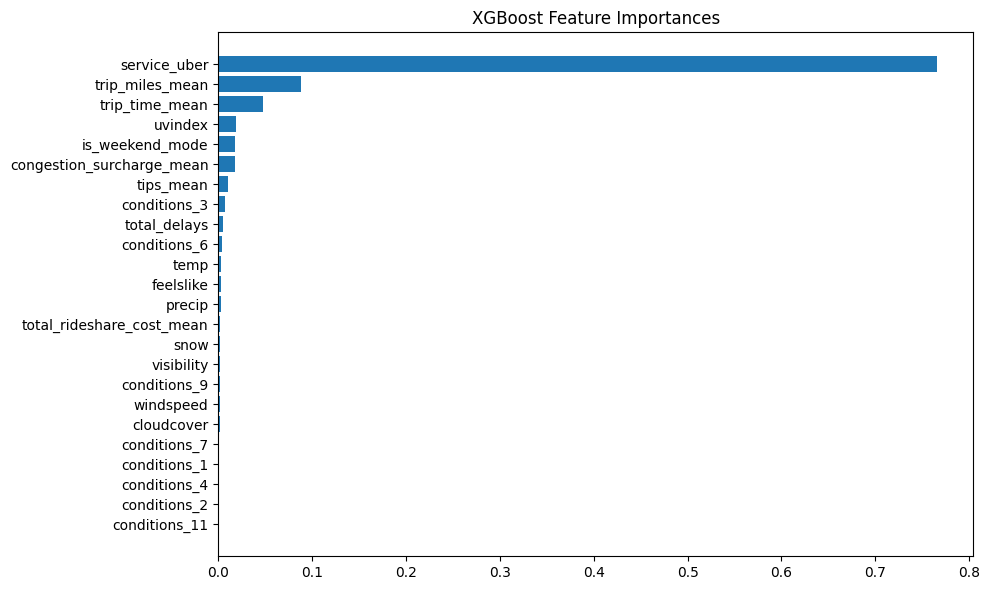

In [26]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Initialize and train model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)

# Evaluate with RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f" XGBoost RMSE: {rmse:.2f}")

# Feature Importance Plot
plt.figure(figsize=(10, 6))
importances = xgb_model.feature_importances_
features = X_processed.columns
sorted_idx = importances.argsort()[::-1]

plt.barh(range(len(importances)), importances[sorted_idx])
plt.yticks(range(len(importances)), features[sorted_idx])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()


/tmp/ipykernel_39533/1313614832.py:9: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


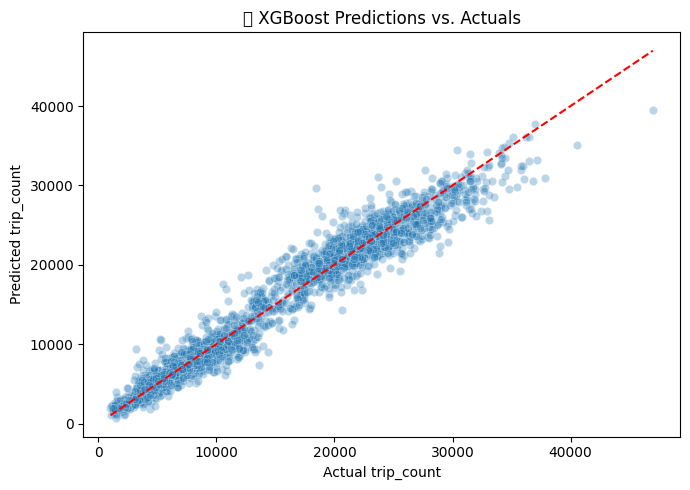

In [ ]:
## ACTUAL VS PREDICTEED SCATTER PLOT

import seaborn as sns

plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel("Actual trip_count")
plt.ylabel("Predicted trip_count")
plt.title("🧪 XGBoost Predictions vs. Actuals")
plt.tight_layout()
plt.show()


/tmp/ipykernel_39533/4179682737.py:11: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


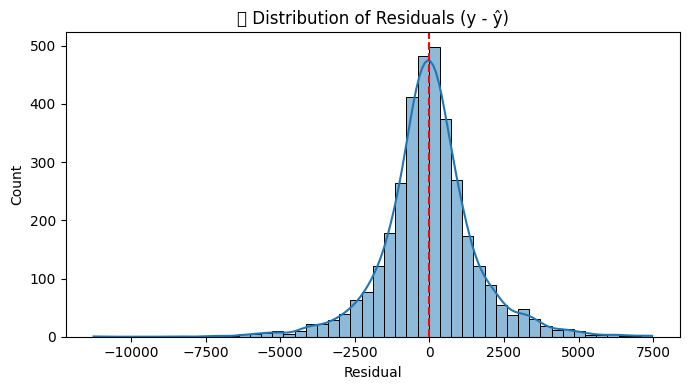

In [28]:
##RESIDUAL PLOT

residuals = y_test - y_pred

plt.figure(figsize=(7, 4))
sns.histplot(residuals, bins=50, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("🔍 Distribution of Residuals (y - ŷ)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


/tmp/ipykernel_39533/134960739.py:8: UserWarning: Glyph 128647 (\N{METRO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128647 (\N{METRO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


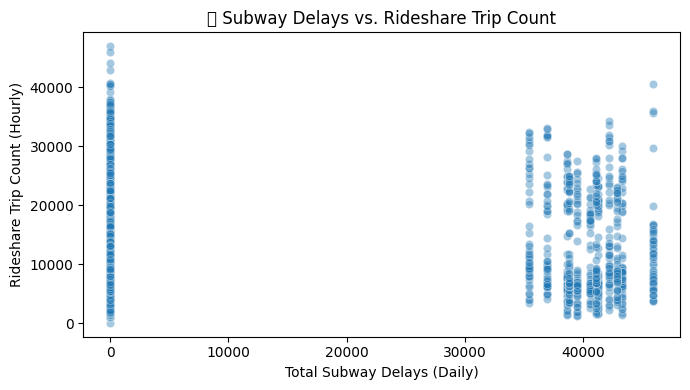

In [29]:
## FEATURE INTERACTION EXPLORATION

plt.figure(figsize=(7, 4))
sns.scatterplot(data=merged_df, x='total_delays', y='trip_count', alpha=0.4)
plt.title("🚇 Subway Delays vs. Rideshare Trip Count")
plt.xlabel("Total Subway Delays (Daily)")
plt.ylabel("Rideshare Trip Count (Hourly)")
plt.tight_layout()
plt.show()


/tmp/ipykernel_39533/705632553.py:16: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


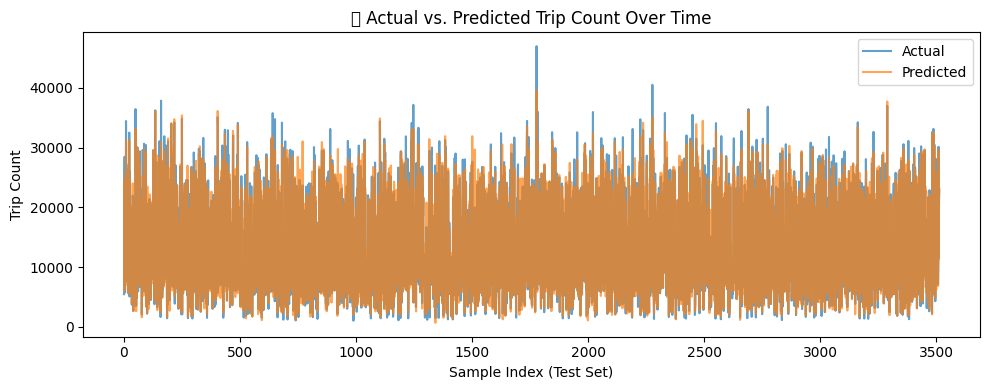

In [30]:
## TIME SERIES OF PREDICTION ERRORS

error_df = X_test.copy()
error_df['actual'] = y_test.values
error_df['predicted'] = y_pred
error_df['error'] = error_df['actual'] - error_df['predicted']

# If 'datetime' is available in X_test
plt.figure(figsize=(10, 4))
plt.plot(error_df['actual'].reset_index(drop=True), label='Actual', alpha=0.7)
plt.plot(error_df['predicted'].reset_index(drop=True), label='Predicted', alpha=0.7)
plt.title("📆 Actual vs. Predicted Trip Count Over Time")
plt.ylabel("Trip Count")
plt.xlabel("Sample Index (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()
